# Globally-Consistent Local Rule-Based Summary-Explanations

Algorithms for generating globally consistent local rule-based summary-explanations. 

Implementation for the algorithms in the paper: _Globally-Consistent Rule-Based Summary-Explanations for Machine Learning Models: Application to Credit-Risk Evaluation_ by [Cynthia Rudin](https://users.cs.duke.edu/~cynthia/) and [Yaron Shaposhnik](https://sites.google.com/view/yarons/home) (link to paper: https://ssrn.com/abstract=3395422)
  

The paper offers a way to understand predictions made by models. It is a _local_ approach, meaning that an "explanation" is generated for any observation and its respective prediction. The novelty of the approach is in creating explanations that are consistent with historical data and cannot be contradicted. These explanations are _rule-based_, which look like: "The model predicts High-Risk for the 742 observations satisfying $x_3\geq 80$ and $x_{21}\leq 100$" (High-Risk is an arbitrary binary label). Such explanation which is generated for a specific observation and given a dataset satisfies the following properties: 
1. It applies to the observation being explained (it must be that $x_3\geq 80$ and $x_{21}\leq 100$ for this observation).
2. In the historical data, __all__ observations satisfying the rule (that is, observations for which $x_3\geq 80$ and $x_{21}\leq 100$, of which there are exactly 742) are labelled High-Risk by the model. 

Explanations are generated by separate algorithms for binary and continuous datasets by solving mixed-integer program and a dynamic programming algorithm. They are evaluated by two metrics: 
* __Sparsity__ - the number of features constituting the rule (i.e., the number of predicates, 2 in the above example ($x_3$ and $x_{21}$)).
* __Support__ - the number of observations in the historical data that are equally labelled and satisfy the rule (742 in the above example).

At a high-level (and slightly differently from the implementation which is somewhat object-oriented) the algorithms can be executed as follows: 
* BinMinSetCover(X, Y_m, x_e, y_m, n_solutions): compute a collection of explanations for an observation (x_e,y_m) using the historical data (X,Y_m). These are n_solutions explanations whose sparsity is minimal.
* BinMaxSupport(X, Y_m, x_e, y_m, maximal_n_terms): returns a single explanation whose support is maximal subject to the requirement that sparsity is smaller than or equal to maximal_n_terms.
* ContMinSetCover(X, Y_m, x_e, y_m, n_solutions): the equivalent of BinMinSetCover for continuous datasets.
* ContMaxSupport(X, Y_m, x_e, y_m, n_solutions):  the equivalent of BinMaxSupport for continuous datasets.

Such rule-based explanations are essentially box-polytopes, defining lower- and upper-bounds for each features. However, to be consistent with the paper, this implementation only includes lower bounds. Generality is not lossed by expanding the features space prior to generating boxes: 
* Binary datasets: X'=[X,1-X]
* Continuous datasets: X'=[X,-X]

For example, the interval bounding a single continuous feature $1 \leq x_7 \leq 10$ can be obtained by adding a feature $x'_7=-x_7$, and requiring that $x_7\geq 1$ and $x'_7\geq -10$.


The implementation is carried through two objects: 
- __RBModel__ - represents a rule-based model (i.e., the lower bounds on each feature)
- __GCRBE_Generator__ - an object that generates rules-based models using data. The object is initialized using the historical data X,Y_m and can then be called with specific observations to be explained by the different algorithms. 


A few notes:
- This implementation is based on [pulp](https://github.com/coin-or/pulp) (in the paper, we used [gurobi](https://www.gurobi.com/)'s Python interface directly). With minor modofications to the code different solvers can be used. 
- Some improvements could be made by using initial solutions in the optimization problems and reducing validation code (many assertions that check that unexpected events do not occur)
- removing print statements
- The parameter `TIME_LIMIT` controls the limit on the optimization running time


In [1]:
from GCRBSE import * # the implementation file
import itertools

## RBModel: Rule-Based Model
RBModel is first and foremost a predictive model. It is initialized by setting 
lower bounds definiting an open box. The model predicts `True` for observations 
that lie within the box and `False` otherwise. RBModel can also store arbitrary 
information in the input parameter `properties` (which is a dictionary).


Initialize RBModel (the box a>=1 AND b>=2) opposite inequalities can be obtained by adding features with opposite values.

In [2]:
rbm1 = RBModel(tau=pd.Series([1,2],index=['a','b']), properties = {})
print('rbm1:', rbm1.__repr__())    

rbm1: {'rule': 'a>=1.00, b>=2.00', 'n_terms': 2}


Determine if observations satisfy rule

In [5]:
print('rbm1: predictions (do observations lie within the box)\n', rbm1.predict([[1,2],[4,5],[0,5],[4,10]]))

rbm1: predictions (do observations lie within the box)
 [[ True]
 [ True]
 [False]
 [ True]]


similarly, only feature 'b' can be ignored here

In [6]:
rbm2 = RBModel(tau=pd.Series([1,-np.inf],index=['a','b']))
print('rbm2:', rbm2.__repr__())    
print('rbm2: predictions\n', rbm2.predict([[1,2],[4,5],[0,5],[4,10]]))

rbm2: {'rule': 'a>=1.00', 'n_terms': 1}
rbm2: predictions
 [[ True]
 [ True]
 [False]
 [ True]]


string representation of rules consolidates features (e.g. 'a') with their complements (a negative feature '-a' and a complementary '~a') 

In [7]:
rbm3 = RBModel(tau=pd.Series([1,2,-3],index=['a','b','-a']))
print('rbm3:', rbm3.__repr__())    

rbm3: {'rule': '1.00<=a<=3.00, b>=2.00', 'n_terms': 2}


In [8]:
rbm4 = RBModel(tau=pd.Series([0,1,0],index=['a','b','~a']))
print('rbm4:', rbm4.__repr__())    

rbm4: {'rule': '0.00<=a<=1.00, b>=1.00', 'n_terms': 2}


In [9]:
rbm5 = RBModel(tau=pd.Series([0,1,1],index=['a','b','~a']))
print('rbm5:', rbm5.__repr__())    

rbm5: {'rule': '0.00<=a<=0.00, b>=1.00', 'n_terms': 2}


Compute the number of observations in a dataset that satisfy the rule while being consistent with a given label (return -1 if inconsistent)


In [11]:
X = np.array([[1,2,3],[0,1,1],[-1,2,2],[np.inf,np.inf,np.inf]])
Y_m = np.array([1,1,1,1])
y_m = 1
print('support:',rbm5.support(X, Y_m, y_m), '(example of a consistent rule)')

support: 3 (example of a consistent rule)


In [13]:
X = np.array([[1,2,3],[0,1,1],[-1,2,2],[np.inf,np.inf,np.inf]])
Y_m = np.array([1,0,1,1])
y_m = 1
print('support:',rbm5.support(X, Y_m, y_m), '(example of an inconsistent rule; returns -1 even though the rule applies to some observations)')

support: -1 (example of an inconsistent rule; returns -1 even though the rule applies to some observations)


## Globally consistent rule-based explanations (GCRBE)

The class 'GCRBE_Generator' generates GCRBEs. GCRBE is a rule-based model that 
is defined with respect to: 
- X - a dataset
- Y_m - corresponding labels generated by a model m    
- (x_e,y_e) - an observation to be explained and its label (generated by the same model)

A GCRBE $h^e$ satisfies three properties: 
1. It is rule-based (RBModel, see above)
2. $h^e$(x_e)=y_e (it is relevant to explaining the observation)
3. $h^e$(x_i)$\neq$y_e for every $x_i \in X$ for which $y_i\neq y_e$ (the explanation provides a sufficient condition for predicting y_e that is consistent with the dataset X and the labels Y_m)
    
Different algorithms are used for binary and continuous datasets: 
- `__BinMinSetCover__(x, y_m, n_solutions)` - find n_solutions most sparse solutions (returns a list of explanations)
- `__BinMaxSupport__(x, y_m, maximal_n_terms)` - find an explanation with maximal support such that the number of features in the rule is at most maximal_n_terms (returns a single explanation)
- `__ContMinSetCover__( x_e, y_m, n_binary_solutions)` - find n_solutions most sparse solutions (returns a list of explanations)
- `__ContMaxSupport__(x_e, y_m, e_list, n_binary_solutions)` - find a maximal support explanation by expanding the explanations in e_list (or by expanding n_binary_solutions explanations generated by ContMinSetCover; returns a single explanation)

The function `generate_explanations_for_training_data` allows generating explanatinos for a batch of observations.



### simple binary dataset


Small dataset:
    x0  x1  y
0   0   0  0
1   0   1  0
2   1   0  0
3   1   1  1


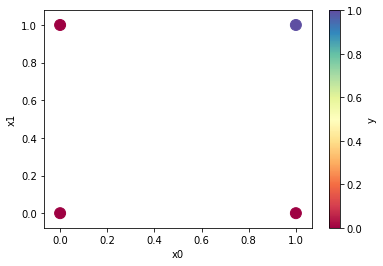

In [15]:
X,y_m = pd.DataFrame(np.array([[0,0],[0,1],[1,0],[1,1]]),columns=['x0','x1']), pd.Series(np.array([0,0,0,1]),name='y')    
df = pd.concat([X,y_m],axis=1)  
print('Small dataset:\n',df)
df.plot.scatter(x='x0',y='x1',c='y', cmap=cm.get_cmap('Spectral'),sharex=False,s=120)
plt.show()

In [16]:
# generate explanations of dataset predictions
rbm_gen = GCRBE_Generator(X, y_m)        
print('rbm_gen', rbm_gen)
i = 3
e_list=rbm_gen.__BinMinSetCover__(X.iloc[i,:], y_m.iloc[i], n_solutions=3)
print('Explanations for observation', i, e_list)

rbm_gen {'features': ['x0', 'x1'], '(n,p)': (4, 2), 'data_type': 'binary'}
Academic license - for non-commercial use only
Explanations for observation 3 [{'time': '0.0', 'type': 'BinMinSetCover', 'rule': 'x0>=1.00, x1>=1.00', 'n_terms': 2, 'support': 1}]


In [17]:
i = 0
e_list=rbm_gen.__BinMinSetCover__(X.iloc[i,:], y_m.iloc[i])
print('Explanations for observation', i, e_list, '(there is no consistent explanation for (0,0) of the form x_?>=?)')

Explanations for observation 0 [] (there is no consistent explanation for (0,0) of the form x_?>=?)


C:\ProgramData\Anaconda3\lib\site-packages\pulp\pulp.py:1354: UserWarning: Overwriting previously set objective.
  warnings.warn("Overwriting previously set objective.")


In [18]:
# expand the feature space        
X = complement_binary_dataframe(X) # expand the binary feature set X=[X,1-X]
df = pd.concat([X,y_m],axis=1)  
print(df)
rbm_gen = GCRBE_Generator(X, y_m)                
i = 0
print('after expanding the feature space explanations can be found:')
for e in rbm_gen.__BinMinSetCover__(X.iloc[i,:], y_m.iloc[i],10): 
    print('   ',e)

   x0  x1  ~x0  ~x1  y
0   0   0    1    1  0
1   0   1    1    0  0
2   1   0    0    1  0
3   1   1    0    0  1
after expanding the feature space explanations can be found:
    x1<=0.00
    x0<=0.00
    x0<=0.00, x1<=0.00


In [20]:
i = 3 
e = rbm_gen.__BinMaxSupport__(X.iloc[i,:], y_m.iloc[i], maximal_n_terms=2)
print('BinMaxSupport:', e.__repr__()) 

BinMaxSupport: {'time': '0.0', 'type': 'BinMaxSupport', 'rule': 'x0>=1.00, x1>=1.00', 'n_terms': 2, 'support': 1}


In [21]:
i = 3
print(rbm_gen.__BinMaxSupport__(X.iloc[i,:], y_m.iloc[i], maximal_n_terms=1), 'there is no consistent explanation to observation 3 with 1 feature')

None there is no consistent explanation to observation 3 with 1 feature


### simple continuous dataset


Small continuous dataset:
    x0  x1  -x0  -x1  y
0  10  10  -10  -10  1
1  10  11  -10  -11  1
2  10  12  -10  -12  1
3  11  10  -11  -10  1
4  11  11  -11  -11  1
5  11  12  -11  -12  0
6  12  10  -12  -10  0
7  12  11  -12  -11  0
8  12  12  -12  -12  0


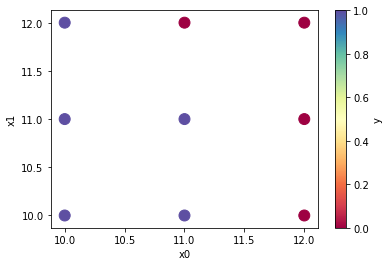

In [22]:
# generate data and plot it
X = pd.DataFrame(np.array([[0,0],[0,1],[0,2],[1,0],[1,1],[1,2],[2,0],[2,1],[2,2]]), columns=['x0','x1'])
Y_m = pd.Series([1,1,1,1,1,0,0,0,0], name='y')
X+=10
X = complement_continuous_dataframe(X) # expand the continuous feature set X=[X,-X] (slightly different from the binary expansion)    
df = pd.concat([X,Y_m], axis=1)    
print('Small continuous dataset:\n',df)
df.plot.scatter(x='x0',y='x1',c='y', cmap=cm.get_cmap('Spectral'),sharex=False,s=120)
plt.show()

In [25]:
# generate ContMinSetCove explanations 
rbm_gen = GCRBE_Generator(X, Y_m)     
i = 0
e_list = rbm_gen.__ContMinSetCover__(x_e=X.iloc[i], y_m=Y_m.iloc[i], n_binary_solutions=10)
print('list of ContMinSetCover explanations for observation %d'%i)
for e in e_list: 
    print('   ',e)

list of ContMinSetCover explanations for observation 0
    x0<=10.00
    x1>=10.00, x0<=10.00
    x0<=10.00, x1<=10.00
    10.00<=x0<=10.00
    10.00<=x0<=10.00, x1>=10.00
    10.00<=x1<=10.00, x0<=10.00
    10.00<=x0<=10.00, x1<=10.00
    10.00<=x0<=10.00, 10.00<=x1<=10.00
    10.00<=x0<=10.00, 10.00<=x1<=10.00
    10.00<=x0<=10.00, 10.00<=x1<=10.00


In [26]:
# generate ContMaxSupport explanations 
i=0
e=rbm_gen.__ContMaxSupport__(x_e=X.iloc[i], y_m=Y_m.iloc[i], e_list=e_list)
print('ContMaxSupport explanation for observation %d'%i, e.__repr__())

ContMaxSupport explanation for observation 0 {'rule': 'x0<=11.00, x1<=11.00', 'n_terms': 2, 'support': 4, 'time': '0.0', 'type': 'ContMaxSupport'}


### generating a batch of explanations

Small dataset:
    x0  x1  ~x0  ~x1  y
0   0   0    1    1  0
1   0   1    1    0  0
2   1   0    0    1  0
3   1   1    0    0  1


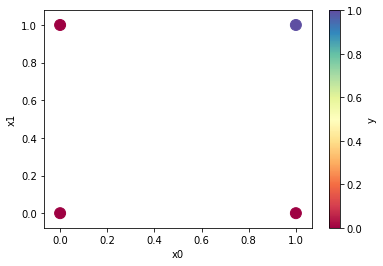

generate_explanations_for_training_data 0 BinMinSetCover
{'n_solutions': 3} [{'time': '0.0', 'type': 'BinMinSetCover', 'rule': 'x1<=0.00', 'n_terms': 1, 'support': 2, 'function_call': (0, 'BinMinSetCover'), 'observation': 0}, {'time': '0.0', 'type': 'BinMinSetCover', 'rule': 'x0<=0.00', 'n_terms': 1, 'support': 2, 'function_call': (0, 'BinMinSetCover'), 'observation': 0}, {'time': '0.0', 'type': 'BinMinSetCover', 'rule': 'x0<=0.00, x1<=0.00', 'n_terms': 2, 'support': 1, 'function_call': (0, 'BinMinSetCover'), 'observation': 0}] 

generate_explanations_for_training_data 1 BinMinSetCover
{'n_solutions': 3} [{'time': '0.0', 'type': 'BinMinSetCover', 'rule': 'x0<=0.00', 'n_terms': 1, 'support': 2, 'function_call': (1, 'BinMinSetCover'), 'observation': 1}, {'time': '0.0', 'type': 'BinMinSetCover', 'rule': 'x1>=1.00, x0<=0.00', 'n_terms': 2, 'support': 1, 'function_call': (1, 'BinMinSetCover'), 'observation': 1}] 

generate_explanations_for_training_data 2 BinMinSetCover
{'n_solutions': 3} [

In [27]:
# generate explanations for a batch of binary observations
X,y_m = pd.DataFrame(np.array([[0,0],[0,1],[1,0],[1,1]]),columns=['x0','x1']), pd.Series(np.array([0,0,0,1]),name='y')    
X = complement_binary_dataframe(X) # expand the binary feature set X=[X,1-X]
df = pd.concat([X,y_m],axis=1)  
print('Small dataset:\n',df)
df.plot.scatter(x='x0',y='x1',c='y', cmap=cm.get_cmap('Spectral'),sharex=False,s=120)
plt.show()

rbm_gen = GCRBE_Generator(X, y_m)            
rbm_list_list = rbm_gen.generate_explanations_for_training_data(range(len(X)), {'BinMinSetCover':{'n_solutions':3}}) # returns list of list of explanations
rbm_list = list(itertools.chain(*rbm_list_list)) # collapses the list of list of explanations to a list of explanations

rbm_list += rbm_gen.generate_explanations_for_training_data(range(len(X)), {'BinMaxSupport':{'n_terms':"minimal+0"}}) # returns list of explanations
rbm_list += rbm_gen.generate_explanations_for_training_data(range(len(X)), {'BinMaxSupport':{'n_terms':"minimal+1"}})
rbm_list += rbm_gen.generate_explanations_for_training_data(range(len(X)), {'BinMaxSupport':{'n_terms':"minimal+-1"}}) # infeasible and ignored

# consolidate datamatrix and explanations into a single dataframe
df['observation']=df.index.values
df_rbm_list = pd.DataFrame(list(map(lambda e_:e_.properties,filter(lambda e_:e_!=None,rbm_list))))
df_rbm_list = df.merge(df_rbm_list, on='observation')
df_rbm_list.to_csv('output.csv')
print(df_rbm_list)


Small continuous dataset:
    x0  x1  -x0  -x1  y
0  10  10  -10  -10  1
1  10  11  -10  -11  1
2  10  12  -10  -12  1
3  11  10  -11  -10  1
4  11  11  -11  -11  1
5  11  12  -11  -12  0
6  12  10  -12  -10  0
7  12  11  -12  -11  0
8  12  12  -12  -12  0


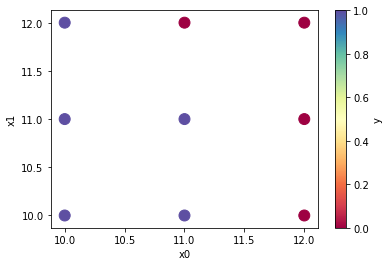

generate_explanations_for_training_data 0 ContMinSetCover
{'n_solutions': 10} [{'time': '0.1', 'type': 'ContMinSetCover', 'rule': 'x0<=10.00', 'n_terms': 1, 'support': 3, 'function_call': (0, 'ContMinSetCover'), 'observation': 0}, {'time': '0.1', 'type': 'ContMinSetCover', 'rule': 'x1>=10.00, x0<=10.00', 'n_terms': 2, 'support': 3, 'function_call': (0, 'ContMinSetCover'), 'observation': 0}, {'time': '0.1', 'type': 'ContMinSetCover', 'rule': 'x0<=10.00, x1<=10.00', 'n_terms': 2, 'support': 1, 'function_call': (0, 'ContMinSetCover'), 'observation': 0}, {'time': '0.1', 'type': 'ContMinSetCover', 'rule': '10.00<=x0<=10.00', 'n_terms': 1, 'support': 3, 'function_call': (0, 'ContMinSetCover'), 'observation': 0}, {'time': '0.1', 'type': 'ContMinSetCover', 'rule': '10.00<=x0<=10.00, x1>=10.00', 'n_terms': 2, 'support': 3, 'function_call': (0, 'ContMinSetCover'), 'observation': 0}, {'time': '0.1', 'type': 'ContMinSetCover', 'rule': '10.00<=x1<=10.00, x0<=10.00', 'n_terms': 2, 'support': 1, 'fun

{'n_solutions': 10} [{'time': '0.1', 'type': 'ContMinSetCover', 'rule': 'x0>=12.00', 'n_terms': 1, 'support': 3, 'function_call': (7, 'ContMinSetCover'), 'observation': 7}, {'time': '0.1', 'type': 'ContMinSetCover', 'rule': 'x0>=12.00, x1>=11.00', 'n_terms': 2, 'support': 2, 'function_call': (7, 'ContMinSetCover'), 'observation': 7}, {'time': '0.1', 'type': 'ContMinSetCover', 'rule': '12.00<=x0<=12.00', 'n_terms': 1, 'support': 3, 'function_call': (7, 'ContMinSetCover'), 'observation': 7}, {'time': '0.1', 'type': 'ContMinSetCover', 'rule': 'x0>=12.00, x1<=11.00', 'n_terms': 2, 'support': 2, 'function_call': (7, 'ContMinSetCover'), 'observation': 7}, {'time': '0.1', 'type': 'ContMinSetCover', 'rule': 'x0>=12.00, 11.00<=x1<=11.00', 'n_terms': 2, 'support': 1, 'function_call': (7, 'ContMinSetCover'), 'observation': 7}, {'time': '0.1', 'type': 'ContMinSetCover', 'rule': '12.00<=x0<=12.00, x1>=11.00', 'n_terms': 2, 'support': 2, 'function_call': (7, 'ContMinSetCover'), 'observation': 7}, {'

In [28]:
# generate explanations for a batch of continuous observations
X = pd.DataFrame(np.array([[0,0],[0,1],[0,2],[1,0],[1,1],[1,2],[2,0],[2,1],[2,2]]), columns=['x0','x1'])
Y_m = pd.Series([1,1,1,1,1,0,0,0,0], name='y')
X+=10
X = complement_continuous_dataframe(X) # expand the continuous feature set X=[X,-X] (slightly different from the binary expansion)    
df = pd.concat([X,Y_m], axis=1)    
print('Small continuous dataset:\n',df)
df.plot.scatter(x='x0',y='x1',c='y', cmap=cm.get_cmap('Spectral'),sharex=False,s=120)
plt.show()

# generate ContMinSetCove explanations 
rbm_gen = GCRBE_Generator(X, Y_m)     
rbm_list_list = rbm_gen.generate_explanations_for_training_data(range(len(X)), {'ContMinSetCover':{'n_solutions':10}})
rbm_list = list(itertools.chain(*rbm_list_list)) # collapse list of list of explanations to list of explanations

rbm_list += rbm_gen.generate_explanations_for_training_data(range(len(X)), {'ContMaxSupport':{'n_solutions':10}})
df_rbm_list = pd.DataFrame(list(map(lambda c:c.properties,rbm_list)))
df_rbm_list.to_csv('output.csv')
print(df_rbm_list)
